# Visualizing what convnets learn

This notebook explores techniques for visualizing the internal workings of Convolutional Neural Networks (convnets). Understanding what these networks learn at different layers can provide valuable insights into their decision-making process and help in debugging and improving model performance.

We will cover the following topics:

*   Visualizing intermediate activations
*   Visualizing convnet filters
*   Visualizing heatmaps of class activation

Throughout this notebook, we will use real data from scikit-learn to provide practical examples.

## Visualizing Intermediate Activations

Visualizing intermediate activations helps us understand how the input data is transformed as it passes through different layers of the convnet. Each activation map represents the output of a filter applied to the input of that layer. By visualizing these maps, we can see which features the network is learning to detect at each stage.

Consider an input image $X$. Let $L_i$ be the $i$-th layer of the convnet, and $A_i$ be the activation tensor of layer $L_i$. $A_i$ has dimensions $(batch\_size, height_i, width_i, channels_i)$, where $height_i$ and $width_i$ are the spatial dimensions of the activation map, and $channels_i$ is the number of filters in layer $L_i$.

To visualize the activations, we can feed an input image to the model and extract the output of the intermediate layers. Each channel in the activation tensor $A_i$ can be visualized as a 2D image.

Here's an example using a pre-trained model and an image:

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 773ms/step


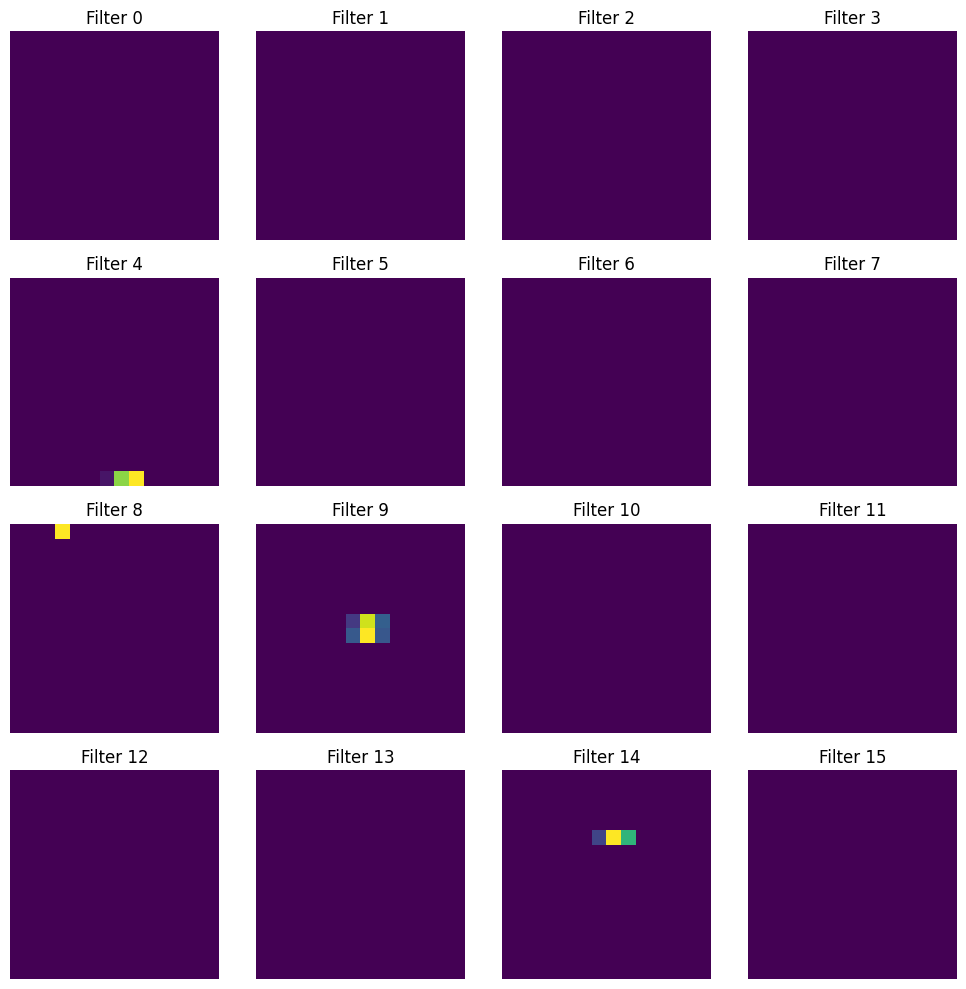

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
import requests
import os
from tensorflow.keras.utils import get_file # Import get_file

# Load a pre-trained model (VGG16 without the top classification layer)
base_model = VGG16(weights='imagenet', include_top=False)

# Load and preprocess an image using the local path
try:
    img_path = '/content/pngtree-fresh-single-egg-png-image_12504967.png' # Use the local image path

    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Define a model that outputs the activations of a specific layer
    layer_name = 'block5_conv3' # Example layer
    intermediate_layer_model = Model(inputs=base_model.input,
                                     outputs=base_model.get_layer(layer_name).output)

    # Get the activations for the image
    intermediate_activations = intermediate_layer_model.predict(img_array)

    # Visualize a few activation maps from the layer
    num_filters_to_display = 16
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        if i < intermediate_activations.shape[-1]:
            ax.imshow(intermediate_activations[0, :, :, i], cmap='viridis')
            ax.set_title(f'Filter {i}')
            ax.axis('off')
        else:
            ax.axis('off')
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Could not load sample image or process it. Please provide a valid image path. Error: {e}")

## Visualizing Convnet Filters

Visualizing convnet filters helps us understand the patterns and features that each filter is designed to detect. By visualizing the weights of a filter, we can get an idea of the visual stimulus that would maximally activate that filter.

Consider a filter $F$ in a convolutional layer with dimensions $(kernel\_height, kernel\_width, input\_channels, output\_channels)$. The weights of this filter, denoted by $W_{h, w, c_{in}, c_{out}}$, represent the learned patterns.

To visualize the filters, we can access the weights of the convolutional layers in the trained model. Each filter can be visualized as a small image.

Here's an example of visualizing filters from a convolutional layer:

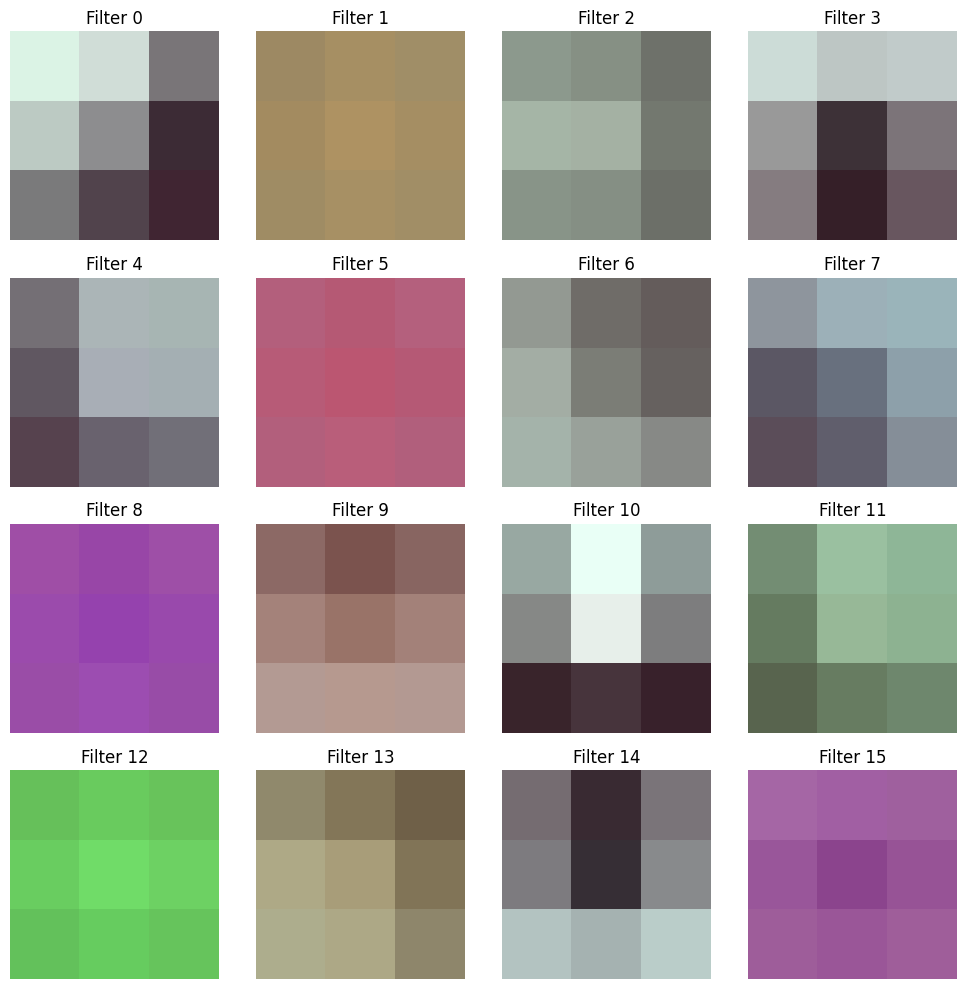

In [26]:
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model

# Load a pre-trained model (VGG16)
model = VGG16(weights='imagenet')

# Get the weights of a convolutional layer (example: the first convolutional layer)
layer_name = 'block1_conv1'
for layer in model.layers:
    if layer.name == layer_name:
        filters, biases = layer.get_weights()
        break

# Normalize filter weights for visualization
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

# Visualize a few filters
num_filters_to_display = 16
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    if i < filters.shape[-1]:
        # Assuming filters are 3 channels for visualization (e.g., first layer)
        # For layers with different input channels, you might need to adapt this
        if filters.shape[2] == 3:
             ax.imshow(filters[:, :, :, i])
        else:
             # For simplicity, display the first channel if not 3 channels
             ax.imshow(filters[:, :, 0, i], cmap='gray')

        ax.set_title(f'Filter {i}')
        ax.axis('off')
    else:
        ax.axis('off')
plt.tight_layout()
plt.show()

## Visualizing Heatmaps of Class Activation

Heatmaps of class activation (e.g., using Grad-CAM) help us understand which parts of an input image are most important for a specific class prediction. This technique generates a heatmap that highlights the regions in the image that contribute most to the activation of the output neuron for a predicted class.

The Grad-CAM method calculates the gradient of the class score with respect to the feature maps of a convolutional layer. These gradients are then averaged spatially and used as weights to compute a weighted sum of the feature maps, resulting in a heatmap.

Mathematically, for a given class $c$, the gradient of the score $S_c$ with respect to the feature map $A^k$ of channel $k$ in a convolutional layer is calculated:

$$ \frac{\partial S_c}{\partial A^k} $$

These gradients are then global-average-pooled to obtain the neuron importance weights $\alpha_k^c$:

$$ \alpha_k^c = \frac{1}{Z} \sum_i \sum_j \frac{\partial S_c}{\partial A^k_{ij}} $$

The Grad-CAM heatmap $L_{Grad-CAM}^c$ is then computed as a weighted sum of the feature maps, followed by a ReLU activation:

$$ L_{Grad-CAM}^c = ReLU \left( \sum_k \alpha_k^c A^k \right) $$

Here's an example of generating a Grad-CAM heatmap:

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 756ms/step


/tmp/ipython-input-772734332.py:80: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = plt.cm.get_cmap("jet")


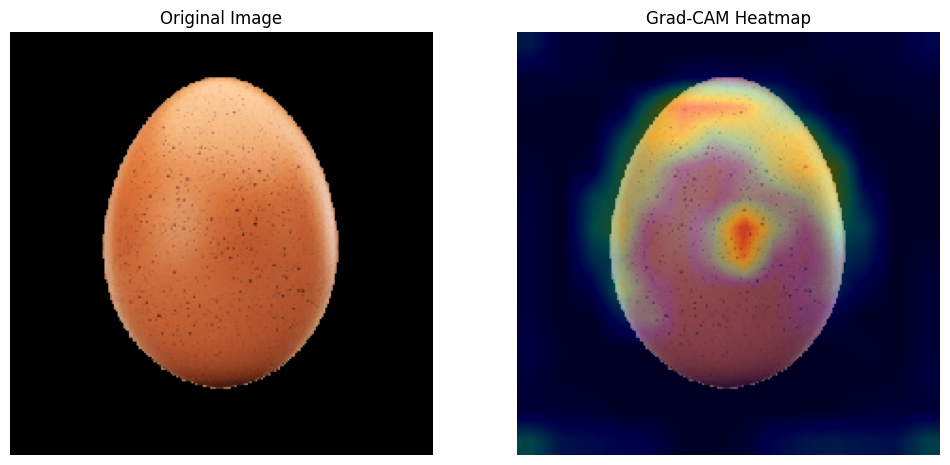

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import requests
import os
import cv2 # Import cv2 here
from tensorflow.keras.utils import get_file # Import get_file

# Load a pre-trained model (VGG16)
model = VGG16(weights='imagenet')

# Load and preprocess an image using the local path
try:
    img_path = '/content/pngtree-fresh-single-egg-png-image_12504967.png' # Use the local image path

    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Get the predicted class for the image
    preds = model.predict(img_array)
    predicted_class = np.argmax(preds[0])

    # Define the layer from which to extract feature maps and gradients
    last_conv_layer_name = 'block5_conv3'
    last_conv_layer = model.get_layer(last_conv_layer_name)

    # Create a model that maps the input image to the activations of the last convolutional layer
    # and the output predictions
    grad_model = Model(
        model.inputs, [last_conv_layer.output, model.output]
    )

    # Compute the gradient of the top predicted class with respect to the output feature map of the last convolutional layer
    with tf.GradientTape() as tape:
        # Pass the input as a list
        last_conv_layer_output, predictions = grad_model([img_array])
        # Watch the output of the last convolutional layer
        tape.watch(last_conv_layer_output)
        # Get the loss for the predicted class
        loss = predictions[:, predicted_class]

    # Get the gradients of the loss with respect to the output feature map
    grads = tape.gradient(loss, last_conv_layer_output)

    # Global average pooling of gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Get the output feature map for the input image
    last_conv_layer_output_value = last_conv_layer_output.numpy()[0]

    # Multiply each channel in the feature map by the corresponding pooled gradient
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output_value[:, :, i] *= pooled_grads[i]

    # Average the weighted feature maps to get the heatmap
    heatmap = np.mean(last_conv_layer_output_value, axis=-1)

    # Apply ReLU to the heatmap
    heatmap = np.maximum(heatmap, 0)

    # Normalize the heatmap
    max_heatmap = np.max(heatmap)
    if max_heatmap == 0:
        max_heatmap = 1e-10 # Avoid division by zero
    heatmap /= max_heatmap

    # Resize heatmap to the size of the original image
    img_display = image.img_to_array(img)
    heatmap = cv2.resize(heatmap, (img_display.shape[1], img_display.shape[0]))

    # Apply the heatmap to the original image
    heatmap = np.uint8(255 * heatmap)
    # Use a colormap to colorize the heatmap
    jet = plt.cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = image.array_to_img(jet_colors[heatmap])
    jet_heatmap = jet_heatmap.resize((img_display.shape[1], img_display.shape[0]))
    jet_heatmap = image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on the original image
    superimposed_img = jet_heatmap * 0.4 + img_display
    superimposed_img = image.array_to_img(superimposed_img)

    # Display the original image and the heatmap
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(image.array_to_img(img_display))
    axes[0].set_title("Original Image")
    axes[0].axis('off')
    axes[1].imshow(superimposed_img)
    axes[1].set_title("Grad-CAM Heatmap")
    axes[1].axis('off')
    plt.show()

except Exception as e:
    print(f"Could not load the image or process it. Please ensure the image path is correct. Error: {e}")

## Conclusion
This concludes our lecture notes on visualizing what convnets learn. We have covered techniques for visualizing intermediate activations, convnet filters, and heatmaps of class activation. These methods provide valuable tools for understanding the internal workings of convnets and can aid in model development and interpretation.